In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm 
import pickle
import random as rd
import itertools
from scipy.stats import qmc, ttest_ind
import scipy.stats as stats


In [134]:
np.random.seed(4227423)

### QUESTION 1

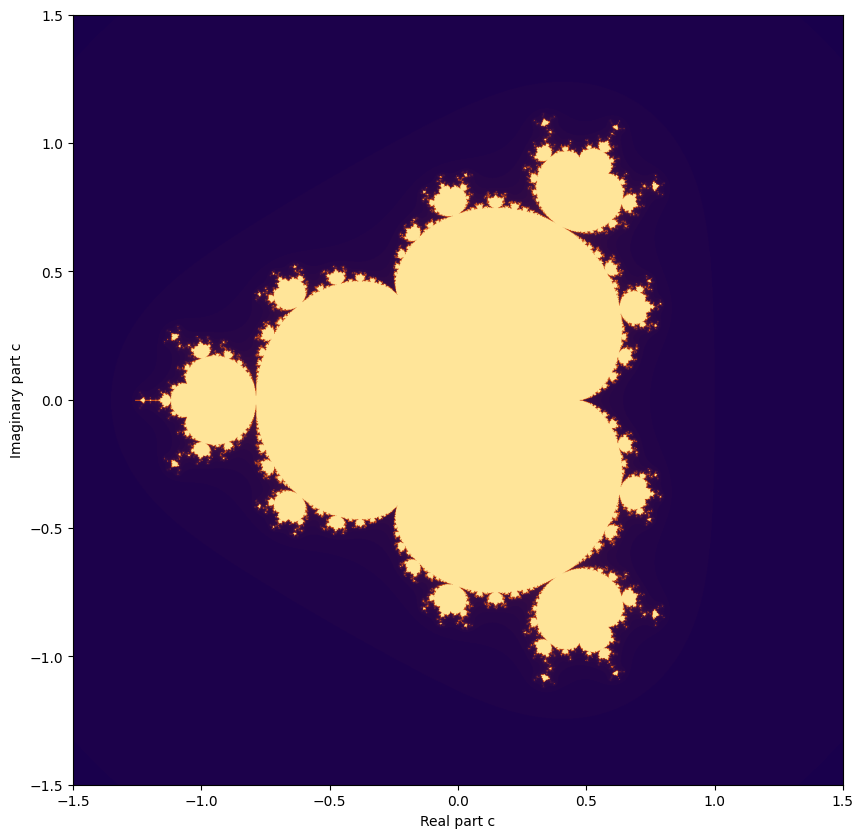

In [3]:
# set graph size and axes 
width, height = 1500, 1500
x_min, x_max = -1.5, 1.5 # used -1.5, 1.5 for plots
y_min, y_max = -1.5, 1.5 # used -1.5, 1.5 for plots

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# Iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        # change **d for m2 m3 and m4
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**4 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
# plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.show()

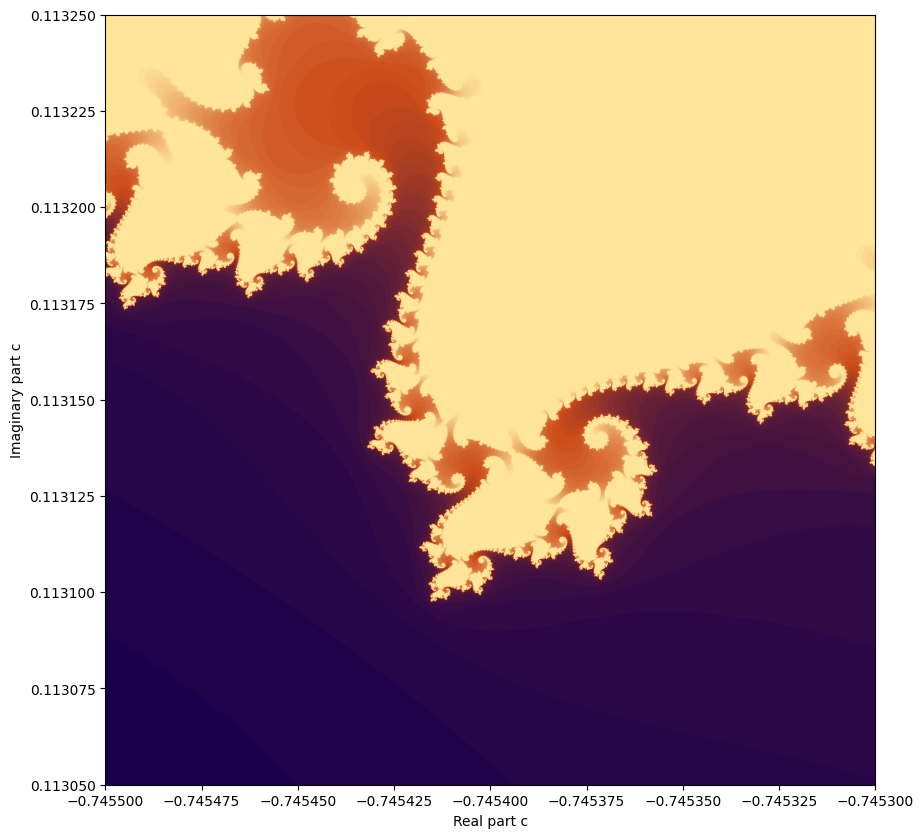

In [4]:
# set graph size and axes
width, height = 2000, 2000
# zoom 1
# x_min, x_max = -1.405, -1.395
# y_min, y_max = -0.005, 0.005
# zoom2
x_min, x_max = -0.7455, -0.7453
y_min, y_max = 0.11305, 0.11325

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**2 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
# plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.show()

### QUESTION 2 & 3

In [282]:
def monte_carlo(n_samples, sample_type,  n_iterations, y_min, y_max, x_min, x_max): 
    """
    Monte carlo integration with three sampling methods
    1. Pure random sampling
    2. Latin hypercube sampling
    3. Orthogonal sampling
    """
    true_count = 0      

    if sample_type == "lhs": 
        points = lhs_qmc(n_samples, y_min, y_max, x_min, x_max)
    elif sample_type == "orthogonal":
        points = orthogonal_sample(n_samples, x_min, x_max, y_min, y_max)
    elif sample_type == "pure_random": 
        points = pure_radom_sample(y_min, y_max, x_min, x_max, n_samples)


    for i in range(len(points)): 
        x_coordinate, y_coordinate, complex_element = points[i][0], points[i][1], points[i][2]

        if mandel_check(complex_element, n_iterations):
            true_count +=1 

    area_total = (x_max-x_min)*(y_max-y_min)
    mandel_area = (true_count/(n_samples)) * area_total
    print(f"Estimated area for {n_samples} samples and {n_iterations} iterations: {mandel_area}")
    return mandel_area

def calculate_Am(): 
    pass 

def mandel_check(complex_number, max_iteration): 
    """
    Check if point belongs to Mandelbrot set or not
    """
    z = 0
    for _ in range(max_iteration): 
        z = z**2 + complex_number
        if abs(z) > 2: 
            return False
    return True

def pure_radom_sample(y_min, y_max, x_min, x_max, n_samples):
    """
    Pure random sampling
    """
    samples = [] 
    for _ in range(n_samples): 
        x_coordinate = rd.uniform(x_min, x_max)
        y_coordinate  = rd.uniform(y_min, y_max)
        complex_element = complex(x_coordinate,y_coordinate)
        samples.append([x_coordinate, y_coordinate, complex_element])

    return samples


def lhs_qmc(n_samples, y_min, y_max, x_min, x_max):
    """
    Latin hypercube sampling
    """
    sampler = qmc.LatinHypercube(d=2)  

    # generate  samples
    lhs_samples = sampler.random(n=n_samples)

    # Rescale 
    x_coordinates_rescaled = x_min + (x_max - x_min) * lhs_samples[:, 0]
    y_coordinates_rescaled = y_min + (y_max - y_min) * lhs_samples[:, 1]
    complex_elements = x_coordinates_rescaled + 1j * y_coordinates_rescaled

    # Combine
    samples = np.column_stack((x_coordinates_rescaled, y_coordinates_rescaled, complex_elements)).tolist()
    
    return samples
 

def orthogonal_sample(n_samples, x_min, x_max, y_min, y_max): 
    """
    Orthogonal sampling
    """
    blocks = int(np.sqrt(n_samples))
    samples = [] 


    # create two squares
    xlist = np.arange(0,blocks*blocks,dtype=int).reshape(blocks,blocks)
    ylist = np.arange(0,blocks*blocks,dtype=int).reshape(blocks,blocks)

    # np.random.shuffle(xlist)
    # np.random.shuffle(ylist)

    for i in range(len(xlist)):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i])
    
    # scale and create random
    for i in range(blocks):
        for j in range(blocks):
            x_coordinate = x_min + ((x_max-x_min) / n_samples) * ( xlist[i][j] + np.random.random())
            y_coordinate = y_min + ((y_max-y_min) / n_samples) * ( ylist[j][i] + np.random.random())
            complex_element = complex(x_coordinate, y_coordinate)
            samples.append([x_coordinate, y_coordinate, complex_element])

    return samples

In [3]:
"""
Initialize hyperparameters for running simulation

*Notes: 
- this code needs to be ran in order for plots to work
- this code neds to be runned for simulations to work
"""

# set sampling algorithm
sample_types = ["pure_random", "lhs", "orthogonal"]  # alternitive: "pure_random", "orthogonal" 
# set number of iterations
n_it = [100,250,500]
# set sample size
n_samples = [900, 8100, 22500, 44100, 72900, 108900, 129600, 152100, 176400, 202500, 230400, 260100,291600, 324900, 360000, 396900, 435600, 476100, 525625, 562500, 656100, 756900]
 #900,1600,2500,3600,4900,6400,8100,10000,12100,14400,16900,19600,22500]

# Variables Am 
Am_samples = 1000000 # 10**6 
Am_iterations = 1000 # 10**6 




for n in n_samples:
    if not np.sqrt(n).is_integer():
        raise ValueError (f"{n}")


# complex plain boundaries: y_min, y_max
x_min, x_max = -2, 2
y_min, y_max = -2, 2

In [284]:
"""
Main run

Results are stored in results_2_3_ and can be retrieved in the next block of code

Warning: running time can be long
"""
# loop over all sample types
for sample_type in sample_types:
      with open(f"main_results/{sample_type}_Am.pkl", "wb") as f:
            results = [monte_carlo(Am_samples, sample_type, Am_iterations, y_min, y_max, x_min, x_max) for _ in range(50)]
            pickle.dump(results, f)
      # loop over iterations
      for iteration in n_it:
            # loop over samples
            for n_sample in n_samples: 
                  # open pickle file
                  with open(f"main_results/{sample_type}_with_{iteration}_iterations_and_{n_sample}_samples.pkl", "wb") as f:
                              for _ in range(50):
                                    result = monte_carlo(n_sample,sample_type, iteration,  y_min, y_max, x_min, x_max)
                                    pickle.dump(result, f)

Estimated area for 1000000 samples and 1000 iterations: 1.502016
Estimated area for 1000000 samples and 1000 iterations: 1.512624
Estimated area for 1000000 samples and 1000 iterations: 1.508128
Estimated area for 1000000 samples and 1000 iterations: 1.516624
Estimated area for 1000000 samples and 1000 iterations: 1.507824
Estimated area for 1000000 samples and 1000 iterations: 1.504912
Estimated area for 1000000 samples and 1000 iterations: 1.504864
Estimated area for 1000000 samples and 1000 iterations: 1.508752
Estimated area for 1000000 samples and 1000 iterations: 1.512688
Estimated area for 1000000 samples and 1000 iterations: 1.513168
Estimated area for 1000000 samples and 1000 iterations: 1.512384
Estimated area for 1000000 samples and 1000 iterations: 1.518096
Estimated area for 1000000 samples and 1000 iterations: 1.511216
Estimated area for 1000000 samples and 1000 iterations: 1.500784
Estimated area for 1000000 samples and 1000 iterations: 1.517984
Estimated area for 100000

### Load data

In [4]:
"""
Retrieving data from pickle files
"""
# set confidence level
confidence_level = 0.95

# dictionary for all data
results_by_sample_type = {}

Am_by_sample_type = {} 

# opening pickle files
for sample_type in sample_types:
    # store results of this sample_type
    all_results = []
    # loop over iterations and sample sizes files
    for iteration in n_it:
        for n_sample in n_samples:
            # pickle results
            results = []
            with open(f"main_results/{sample_type}_with_{iteration}_iterations_and_{n_sample}_samples.pkl", "rb") as f:
                try:
                    while True:
                        result = pickle.load(f)
                        results.append(result)
                # end of file 
                except EOFError: 
                    pass  
            results = np.array(results)

            # compute mean of current result with given iteration and given sample size
            mean = np.mean(results, axis=0)
            # compute sd error of current result with given iteration and given sample size
            sd_error = stats.sem(results, axis=0) 
            # compute bound
            h = sd_error * stats.t.ppf((1 + confidence_level) / 2., len(results) - 1)
            # 95% confidence interval = upper_bound - lower_bound
            lower_bound = mean - h
            upper_bound = mean + h
            # append all results to all_results list
            all_results.append((iteration, n_sample, mean, lower_bound, upper_bound))
        # store in dictionary
        results_by_sample_type[sample_type] = all_results

    with open(f"results_2_3_/{sample_type}_Am.pkl", "rb") as f: 
        Am_results = pickle.load(f)
        Am_mean = np.mean(results)
        Am_by_sample_type[sample_type] = Am_mean



### Plot data

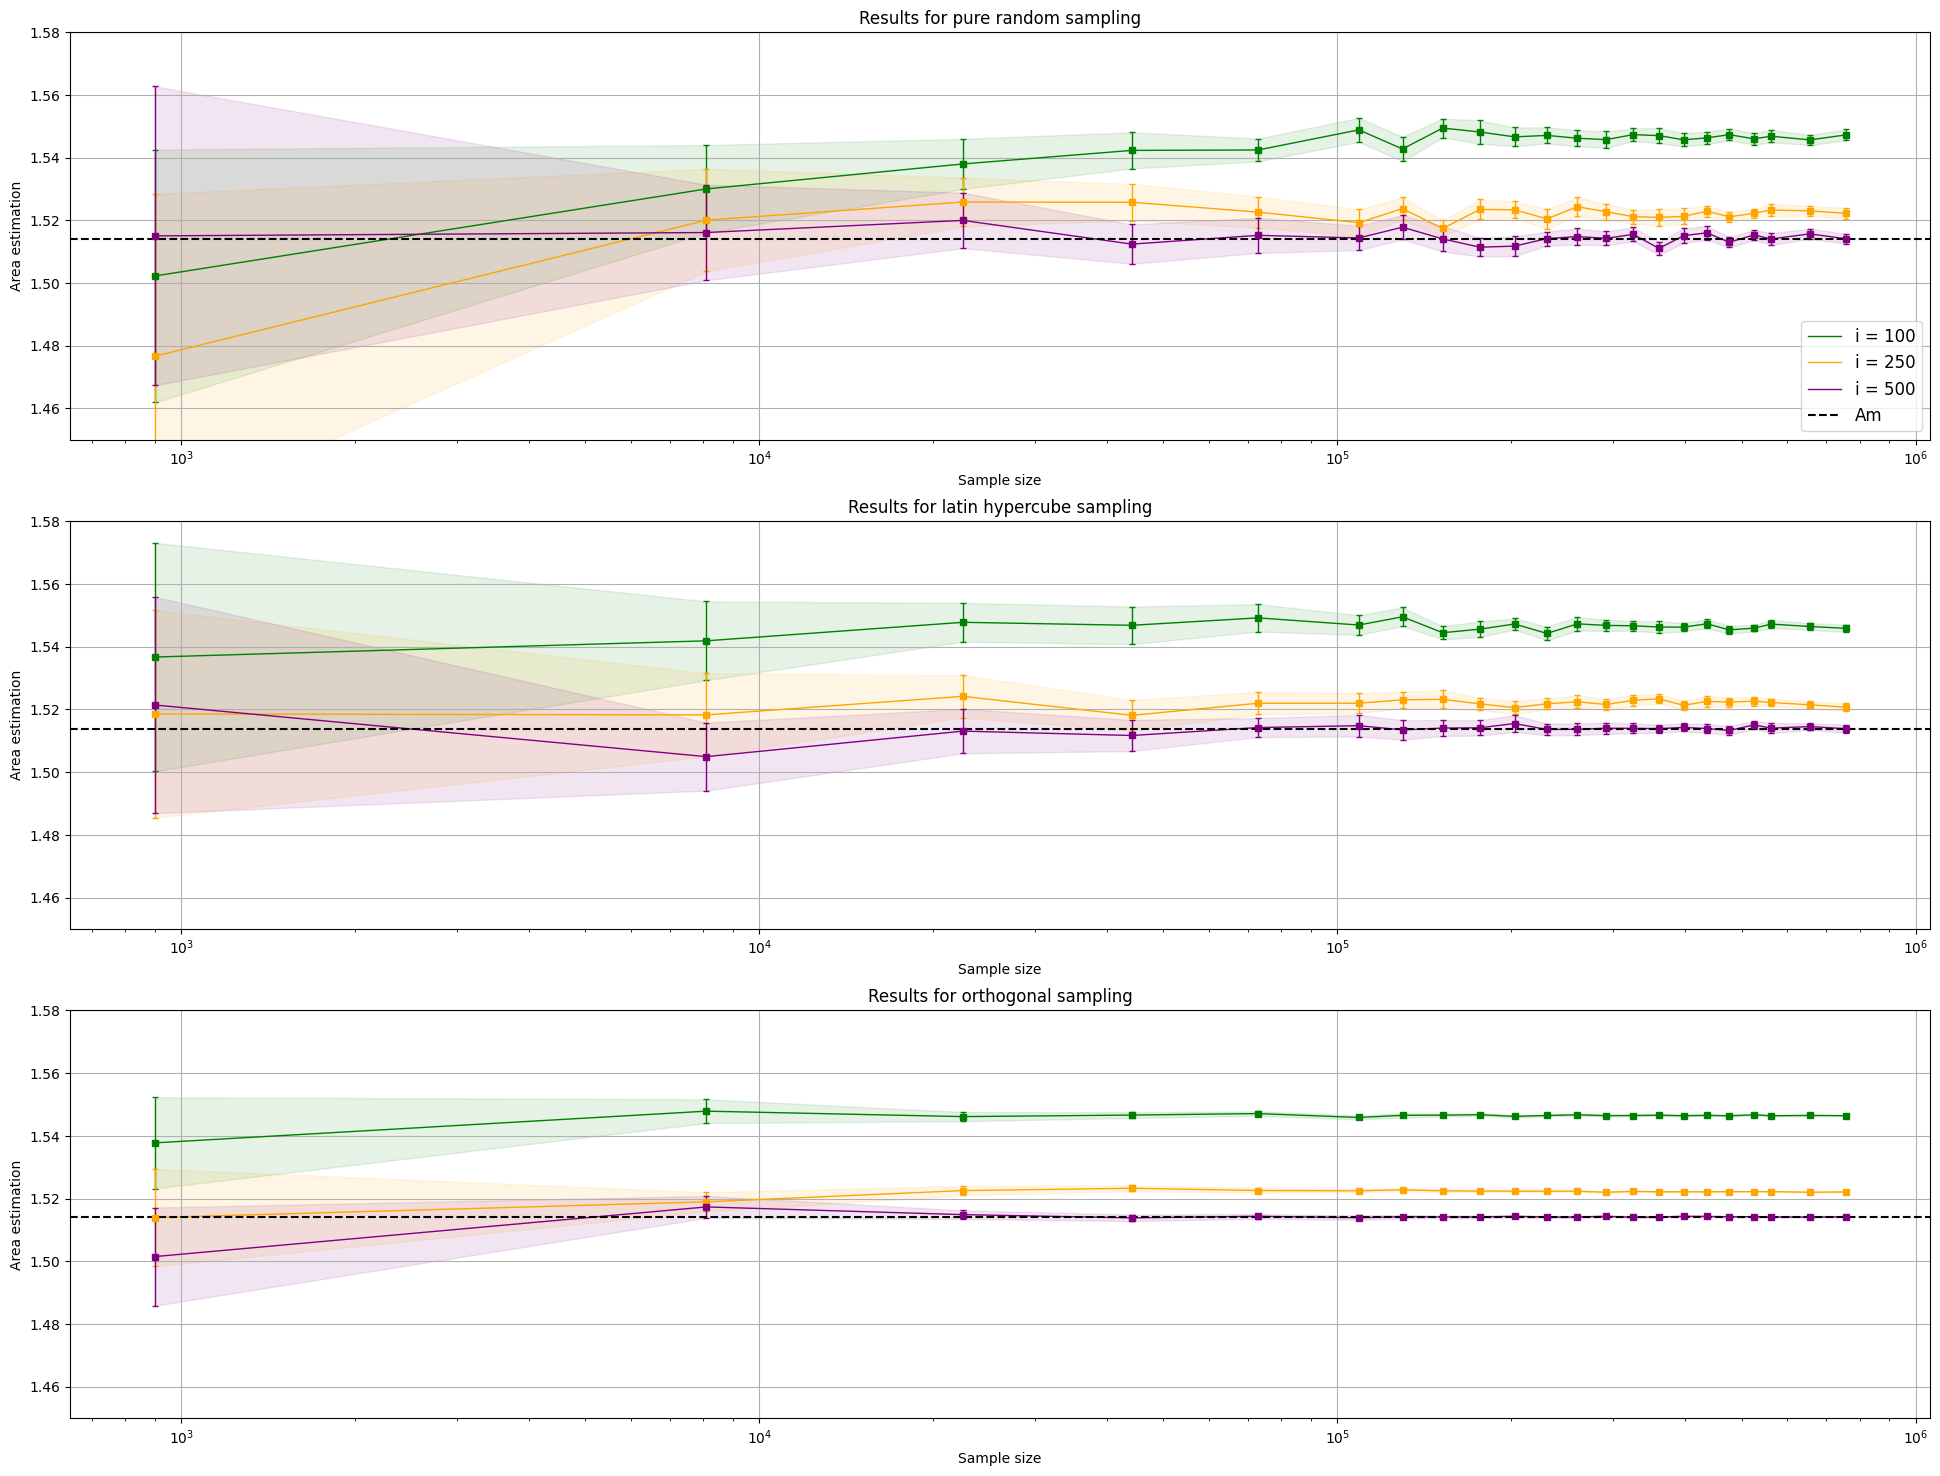

In [11]:
""""
Plots
"""

# initialize plots
fig, axs = plt.subplots(3,1,figsize=(24,18))

# colors for lines
colors = ["green", "orange", "purple"]

# loop over all results
for i, (sample_type, data) in enumerate(results_by_sample_type.items()):
    # results of one sample type

    Am = [Am_by_sample_type[sample_type]]

    for j, current_iteration in enumerate(n_it):
        means = []
        lower_bounds = []
        upper_bounds = []

        # loop through tuples in data
        for iteration, n_sample, mean, lower_bound, upper_bound in data:

            if current_iteration == iteration:
                means.append(mean)
                lower_bounds.append(lower_bound)
                upper_bounds.append(upper_bound)
                
        # plots 
        if means:
            # error bars
            confidence = [np.array(means) - np.array(lower_bounds), np.array(upper_bounds) - np.array(means)]
            axs[i].errorbar(n_samples, means, yerr=confidence, fmt="s", color=colors[j], capsize=2, markersize=4, elinewidth=1)
            # lines
            axs[i].plot(n_samples, means, label = f"i = {current_iteration}", color=colors[j], linewidth=1)
            axs[i].fill_between(n_samples, lower_bounds, upper_bounds, alpha=0.1, color=colors[j])

    axs[i].axhline(y=Am, label="Am", linestyle="--", color="black")
    
    axs[i].set_title(f"Results for {sample_type} sampling")
    if sample_type == "pure_random":
            axs[i].set_title(f"Results for pure random sampling")
    if sample_type == "lhs":
        axs[i].set_title(f"Results for latin hypercube sampling")
    axs[i].set_ylabel("Area estimation")
    axs[i].set_xscale('log')
    axs[i].set_xlabel("Sample size")
    if i == 0:
        axs[i].legend(fontsize="large")
    axs[i].grid()
    axs[i].set_ylim(1.45, 1.58)




[(10, 25, 2.0224, 1.794808782633811, 2.2499912173661896), (10, 81, 2.0227160493827157, 1.9072997327417212, 2.13813236602371), (10, 100, 2.032, 1.9283700941087123, 2.135629905891288), (100, 25, 1.3824, 1.1937360588375774, 1.5710639411624228), (100, 81, 1.544691358024691, 1.4237618398152496, 1.6656208762341325), (100, 100, 1.5552, 1.4588322988285196, 1.6515677011714802), (144, 25, 1.3184, 1.1260152171985123, 1.5107847828014878), (144, 81, 1.5604938271604936, 1.453347990169564, 1.667639664151423), (144, 100, 1.5872000000000002, 1.4900473195189963, 1.684352680481004)]


ValueError: Dimensions of labels and X must be compatible

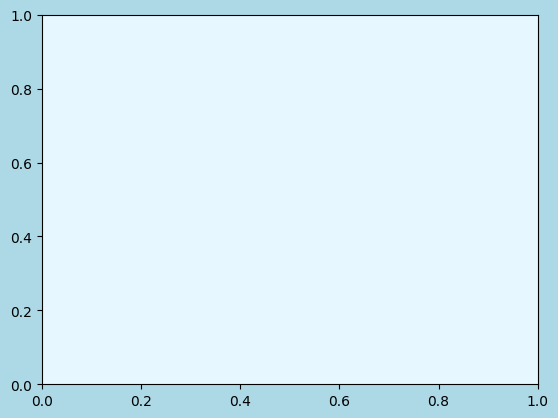

In [54]:
#### TTEST FTEST HERE #### 
#### TO DO TO DO TO D ####

print((all_results))
fig, ax = plt.subplots()
ax.set_facecolor("#e6f7ff")  
fig.set_facecolor("lightblue")

ax.boxplot(all_results, labels=sample_types)
ax.set_title(f"estimations using {n_it[0]} iterations and {n_sample[0]} samples")
ax.set_ylabel('Area estimations')

# ttest
t_stat, p_value = ttest_ind(all_results[0], all_results[1])
print("T-statistic:", t_stat)
print("P-value:", p_value)
alpha = 0.05
if p_value < alpha:
    print("Reject h0. Means are significantly different.")
else:
    print("Fail to reject h0. Means are not significantly different.")








### Iteration Runs ###

Calculating for i = 1000000 iterations: 100%|██████████| 200/200 [12:36<00:00,  3.78s/it]


mean area estimate for i = 1.5030000000000001


Calculating for 100000 iterations: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


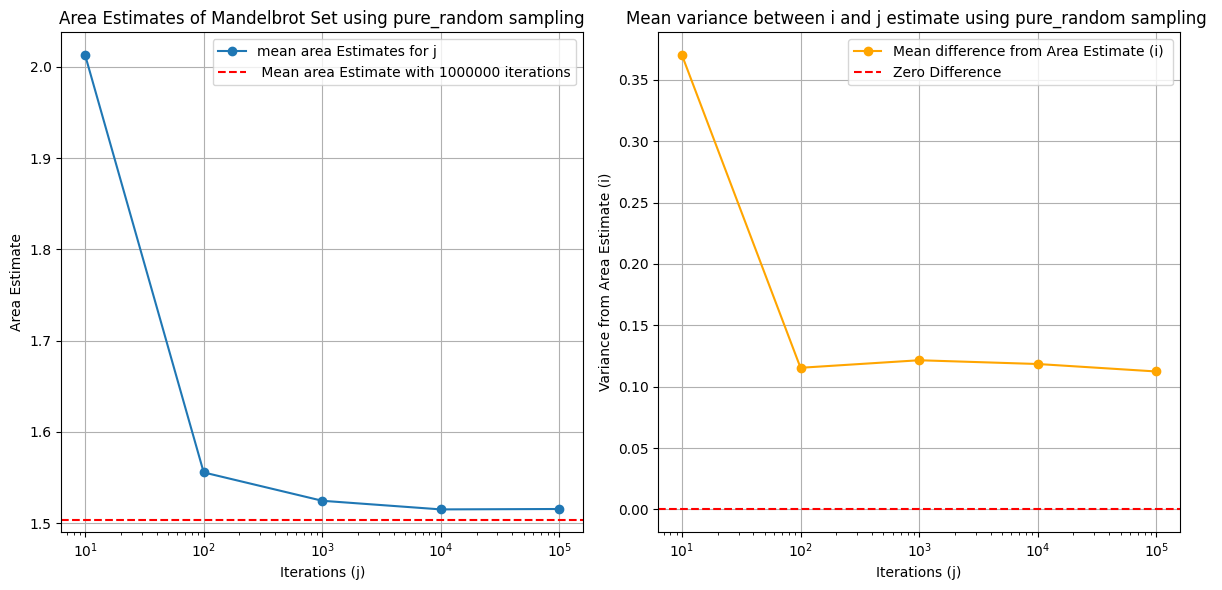

In [235]:


n_runs = 200
samples = 100
i = 1000000
j = [10, 100, 1000, 10000, 100000]# 1000, 10000,100000,1000000] 


def iteration_plot(i, j, samples, sample_type, n_runs): 

    j_estimates = np.zeros(( n_runs, len(j)))
    
    plt.figure(figsize=(12, 6))
    i_estimate = []
    #Get baseline
    for run in tqdm(range(n_runs), desc= f"Calculating for i = {i} iterations"): 
        area_run_i = monte_carlo(samples, sample_type, i, y_min, y_max, x_min, x_max)
        i_estimate.append(area_run_i)
    area_estimate_i = np.mean(i_estimate)
    print(f"mean area estimate for i = {area_estimate_i}")
        


    for setting in range(len(j)): 
        
        for  run in tqdm(range(n_runs), desc= f"Calculating for {j[setting]} iterations"):   
                     
            area_setting_j  = monte_carlo(samples,sample_type, j[setting], y_min, y_max, x_min, x_max)
            j_estimates[run][setting] = area_setting_j
            
        
       
    mean_area = np.mean(j_estimates, axis=0)
    mean_differences = np.mean(np.square(j_estimates - area_estimate_i), axis=0)


    #  j
    plt.subplot(1, 2, 1)
    plt.plot(j, mean_area, marker='o', label=f'mean area Estimates for j')       
    plt.axhline(y=area_estimate_i, color='r', linestyle='--', label=f' Mean area Estimate with {i} iterations')
    plt.title(f'Area Estimates of Mandelbrot Set using {sample_type} sampling')
    plt.xlabel('Iterations (j)')
    plt.xscale("log")
    plt.ylabel('Area Estimate')
    plt.legend()
    plt.grid(True)

    # differences
    plt.subplot(1, 2, 2)
    plt.plot(j, mean_differences, marker='o', color='orange', label=f'Mean difference from Area Estimate (i) ')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
    plt.title(f'Mean variance between i and j estimate using {sample_type} sampling ')
    plt.xlabel('Iterations (j)')
    plt.xscale("log")

    plt.ylabel('Variance from Area Estimate (i)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
        


iteration_plot(i, j, samples, "pure_random", n_runs)



Calculating for i = 1000000 iterations: 100%|██████████| 200/200 [12:02<00:00,  3.61s/it]


mean area estimate for i = 1.5151499999999998


Calculating for 100000 iterations: 100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


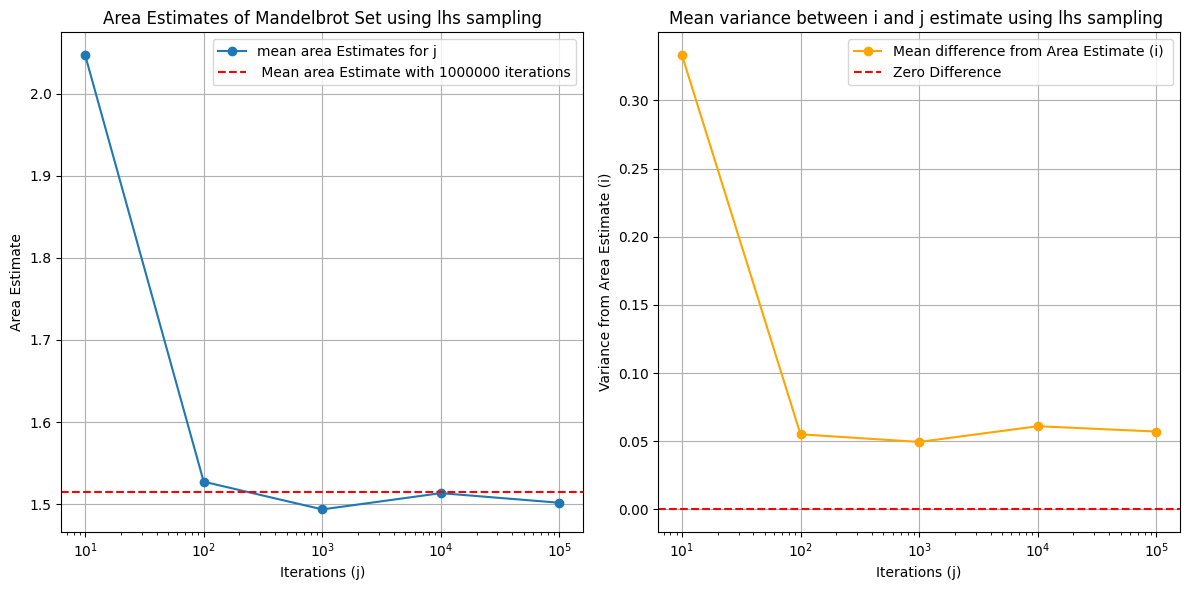

In [ ]:
iteration_plot(i, j , samples, "lhs", n_runs )


Calculating for i = 1000000 iterations: 100%|██████████| 200/200 [11:14<00:00,  3.37s/it]


mean area estimate for i = 1.44


Calculating for 100000 iterations: 100%|██████████| 200/200 [01:07<00:00,  2.95it/s]


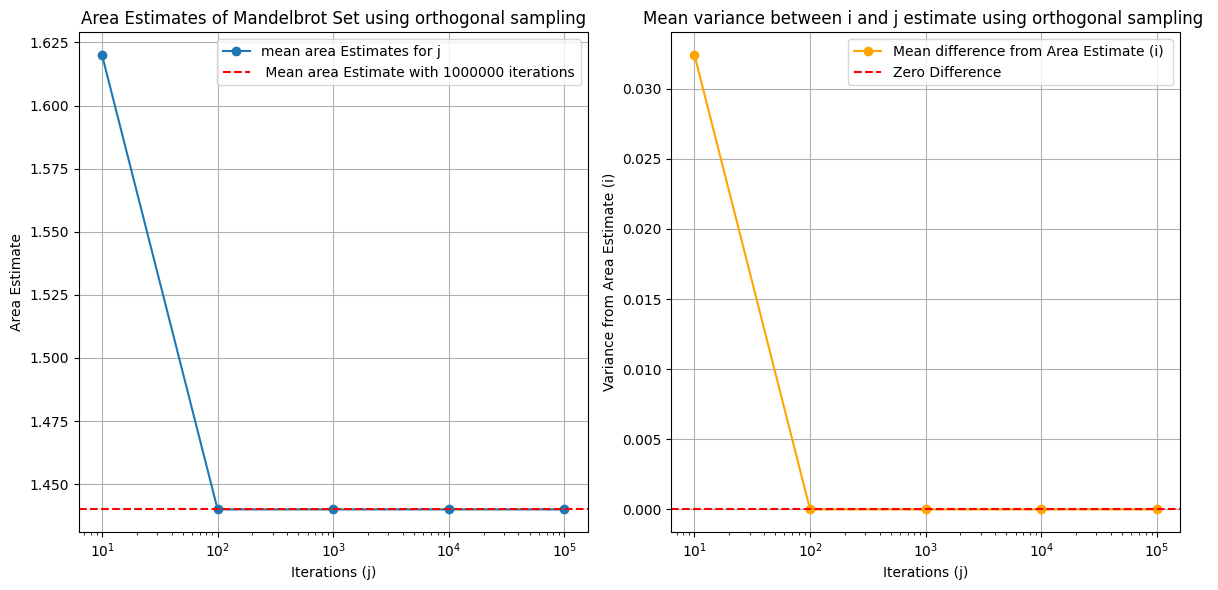

In [ ]:
iteration_plot(i, j, samples, "orthogonal", n_runs)

### Sample Runs ###


Calculating for i = 1000000 samples:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating for i = 1000000 samples: 100%|██████████| 200/200 [19:15<00:00,  5.78s/it]


mean area estimate for i = 1000000 samples: 1.5460797150000003


Calculating for 100000 samples: 100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


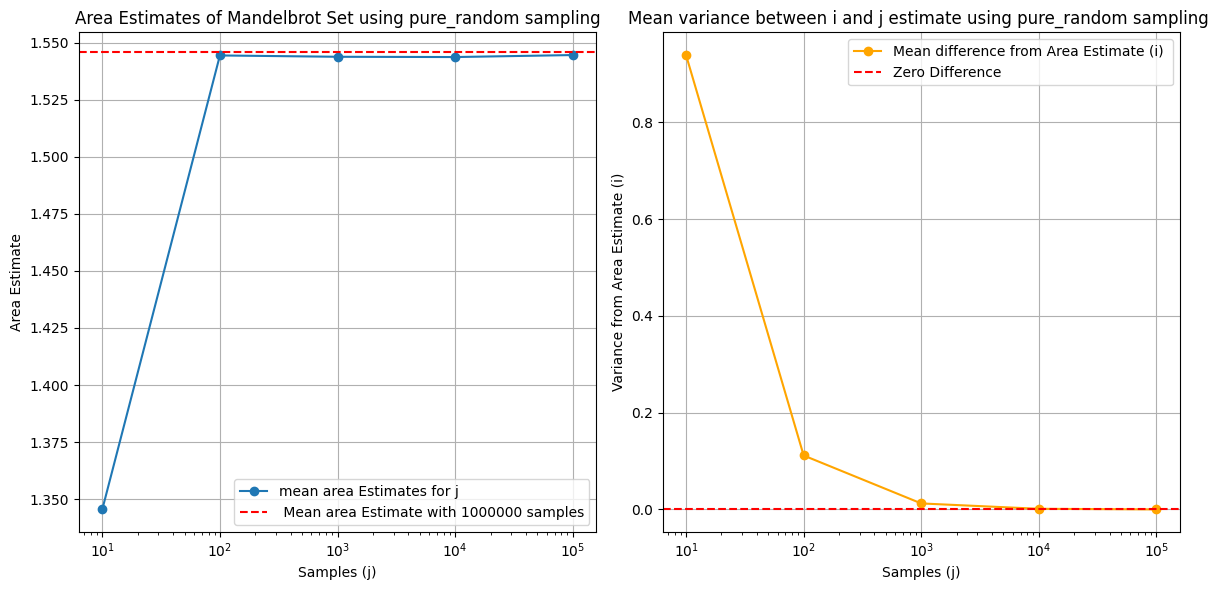

In [ ]:

def compute_variance(area_setimate_i, area_estimate_j):
    squared_difference = (area_estimate_j-area_setimate_i) ** 2
    return squared_difference 

     

n_runs = 200
n_iterations = 100
i = 1000000
j = [10, 100, 1000, 10000, 100000] 


def sample_plot(i, j, n_iterations, sample_type, n_runs): 

    j_estimates = np.zeros(( n_runs, len(j)))
    differences = np.zeros(( n_runs, len(j)))
    
    plt.figure(figsize=(12, 6))
    i_estimate = []
    for run in tqdm(range(n_runs), desc= f"Calculating for i = {i} samples"): 
        area_run_i = monte_carlo(i, sample_type, n_iterations, y_min, y_max, x_min, x_max)
        i_estimate.append(area_run_i)
    area_estimate_i = np.mean(i_estimate)
    print(f"mean area estimate for i = {i} samples: {area_estimate_i}")
        


    for setting in range(len(j)): 
        
        for  run in tqdm(range(n_runs), desc= f"Calculating for {j[setting]} samples"):   
                     
            area_setting_j  = monte_carlo(j[setting],sample_type, n_iterations, y_min, y_max, x_min, x_max)
            variance = compute_variance(area_estimate_i, area_setting_j)

            #differences[run][setting]= variance
            j_estimates[run][setting] = area_setting_j
        
            
        
       
    mean_area = np.mean(j_estimates, axis=0)
    #mean_differences = np.mean(differences, axis = 0 )
    mean_differences = np.mean(np.square(j_estimates - area_estimate_i), axis=0)

    #  j
    plt.subplot(1, 2, 1)
    plt.plot(j, mean_area, marker='o', label=f'mean area Estimates for j')       
    plt.axhline(y=area_estimate_i, color='r', linestyle='--', label=f' Mean area Estimate with {i} samples')
    plt.title(f'Area Estimates of Mandelbrot Set using {sample_type} sampling')
    plt.xlabel('Samples (j)')
    plt.xscale("log")
    plt.ylabel('Area Estimate')
    plt.legend()
    plt.grid(True)

    # differences
    plt.subplot(1, 2, 2)
    plt.plot(j, mean_differences, marker='o', color='orange', label=f'Mean difference from Area Estimate (i) ')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
    plt.title(f'Mean variance between i and j estimate using {sample_type} sampling ')
    plt.xlabel('Samples (j)')
    plt.xscale("log")

    plt.ylabel('Variance from Area Estimate (i)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
        


sample_plot(i, j, n_iterations, "pure_random", n_runs)



Calculating for i = 1000000 samples: 100%|██████████| 200/200 [17:57<00:00,  5.39s/it]


mean area estimate for i = 1000000 samples: 1.545561135


Calculating for 100000 samples: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


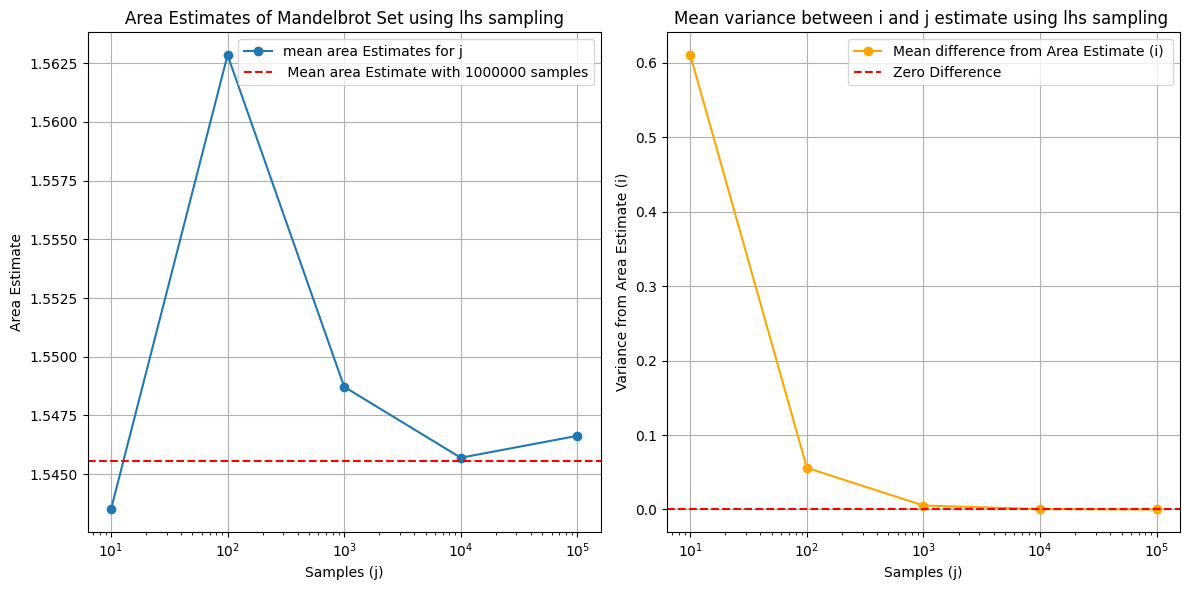

In [ ]:
sample_plot(i, j, n_iterations, "lhs", n_runs)


Calculating for i = 1000000 samples: 100%|██████████| 200/200 [1:58:05<00:00, 35.43s/it]    


mean area estimate for i = 1000000 samples: 1.5429419999999998


Calculating for 100000 samples: 100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


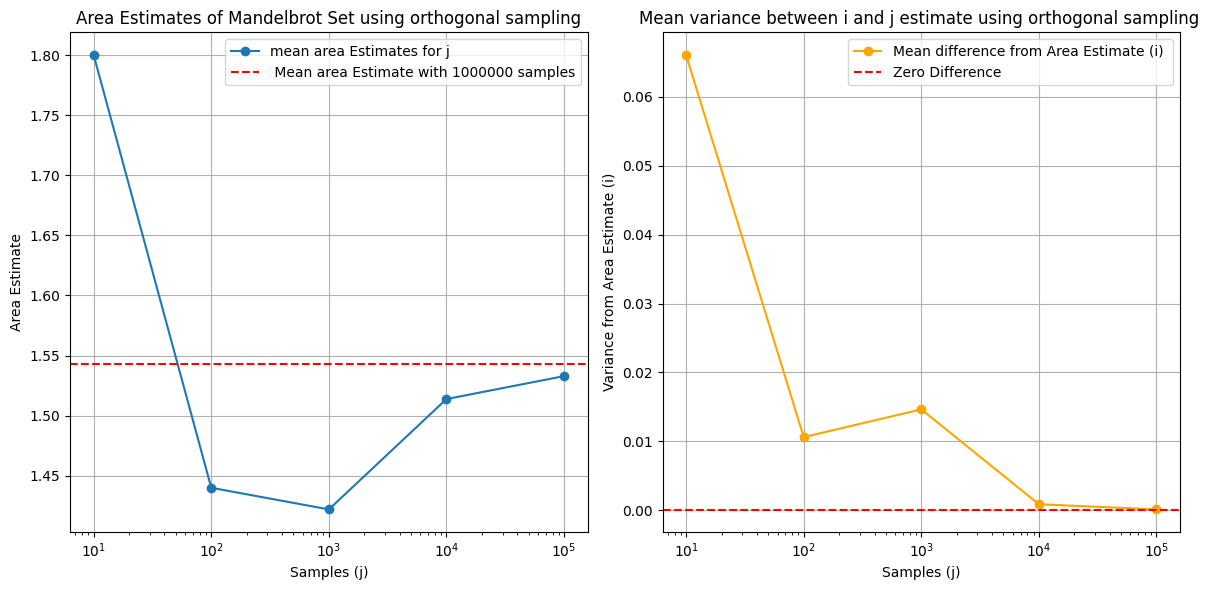

In [ ]:
sample_plot(i, j, n_iterations, "orthogonal", n_runs)
